## Bike Sharing Problem - Model Optimization

This notebook documents the steps taken for model optimization, validation, model explanation, and final model performance. It contains the following steps:

- Model tuning with Bayesian optimization
- Model validation
- Model intepretation with SHapley Additive exPlanations
- Conclusion

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
import lightgbm as lgbm

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.plots import partial_dependence

from prettytable import PrettyTable
np.random.seed(42)

import shap
shap.initjs()

In [2]:
# File path 
base_dir = '/Users/chrisjcc/Downloads/'
data_path = base_dir + 'hour.csv'

# Load data
data = pd.read_csv(data_path) 

### Data preparation

In [4]:
# Preprocessing: Renaming columns names to more readable names
data.rename(columns={'instant':'rec_id',
                     'dteday':'datetime',
                     'holiday':'is_holiday',
                     'workingday':'is_workingday',
                     'weathersit':'weather_condition',
                     'hum':'humidity',
                     'mnth':'month',
                     'cnt':'total_count',
                     'hr':'hour',
                     'yr':'year',
                    },inplace=True)

In [5]:
# Setting proper data types

# date time conversion
data['datetime'] = pd.to_datetime(data.datetime)

# categorical fetures
data['season']     = data.season.astype('category')
data['is_holiday'] = data.is_holiday.astype('category')
data['weekday']    = data.weekday.astype('category')
data['weather_condition'] = data.weather_condition.astype('category')
data['is_workingday']     = data.is_workingday.astype('category')
data['month'] = data.month.astype('category')
data['hour']  = data.hour.astype('category')
data['year']  = data.year.astype('category')

In [6]:
# Brief data check
data.head()

rec_id   datetime season year month hour is_holiday weekday is_workingday  \
0       1 2011-01-01      1    0     1    0          0       6             0   
1       2 2011-01-01      1    0     1    1          0       6             0   
2       3 2011-01-01      1    0     1    2          0       6             0   
3       4 2011-01-01      1    0     1    3          0       6             0   
4       5 2011-01-01      1    0     1    4          0       6             0   

  weather_condition  temp   atemp  humidity  windspeed  casual  registered  \
0                 1  0.24  0.2879      0.81        0.0       3          13   
1                 1  0.22  0.2727      0.80        0.0       8          32   
2                 1  0.22  0.2727      0.80        0.0       5          27   
3                 1  0.24  0.2879      0.75        0.0       3          10   
4                 1  0.24  0.2879      0.75        0.0       0           1   

   total_count  
0           16  
1           40  
2           32  
3           13  
4            1

In [7]:
# Divide the dataset into training and testing sets (randomly and stratified)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-3],  # not include total count, causual, and registered
                                                    data.iloc[:,-1], # set to total_count
                                                    test_size=0.33,
                                                    stratify=None,
                                                    random_state=42)

In [8]:
# Training data used for model developement
X_train.reset_index(inplace=True)
y_train = y_train.reset_index()

# Set aside a hold-out test data used for final model performance
X_test.reset_index(inplace=True)
y_test = y_test.reset_index()
print("We have %d training samples and %d test samples." % (y_train['total_count'].count(), 
                                                            y_test['total_count'].count()))

We have 11643 training samples and 5736 test samples.


We will be using the following features: 

['season', 'month', 'hour', 'is_holiday', 'weekday', 'is_workingday', 'weather_condition', 'temp', 'atemp', 'humidity', 'windspeed']

In [61]:
# Features to drop while model training
ignore_column = ['rec_id', 'index', 'datetime', 'year']

In [62]:
# All the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month']

In [63]:
# Model
models = [
    # specify the training parameters 
    lgbm.sklearn.LGBMRegressor(boosting_type='gbdt',
                               objective='regression',
                               n_estimators=100,
                               min_child_samples=10,  
                               max_depth=-1,
                               learning_rate=0.1,
                               categorical_feature=cat_attr_list,
                               nthread=-1,
                               random_state=42
                              )
]

In [94]:
# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(3, 50, name='max_depth'),
          Integer(300, 1000, name='n_estimators'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          #Categorical(categories=['gbdt', 'dart'], name ='boosting_type')
         ]

In [95]:
# Name of hyper-parameters optimized later used for plot labels
dimensions = ['max_depth', 'n_estimators', 'learning_rate']

In [96]:
# this decorator allows your objective function to receive a the parameters as keyword arguments
@use_named_args(space)
def objective(**params):
    # Set estimator's hyper-parameters
    models[0].set_params(**params)

    # return mean cross-validated negative mean absolute error
    return -1.0 * np.mean(cross_val_score(models[0], 
                                          X_train.drop(ignore_column, axis=1), 
                                          y_train.drop('index', axis=1),
                                          cv=3, 
                                          n_jobs=-1,
                                          scoring="neg_mean_absolute_error" # 'neg_median_absolute_error',
                                         )
                         )

We use the k-fold cross validation to reduce overfitting affects.

## Model tuning using Bayesian  Optimization

We employ a Bayesian optimization approach to tune the model's hyper-parameters.

Bayesian model-based optimization methods build a probability model of the objective function to propose smarter choices for the next set of hyperparameters to evaluate. Sequential Model-Based Optimization (SMBO) is a formalization of Bayesian optimization which is more efficient at finding the best hyperparameters for a machine learning model than random or grid search. In this notebook we use Gaussian Processes as surrogate model.

We are ready to proceed to configure the optimization pipeline process.

In [104]:
%%time
# Bayesian optimization using Gaussian Processes-based optimisation
res_gp = gp_minimize(func=objective, 
                     dimensions=space, 
                     acq_func='gp_hedge', # acquisition function
                     n_calls=20, 
                     random_state=0)

CPU times: user 12.9 s, sys: 1.53 s, total: 14.4 s
Wall time: 26.4 s


Note: "gp_hedge" Probabilistically choose one of the followingacquisition functions: "LCB" for lower confidence bound, "EI" for negative expected improvement, "PI" for negative probability of improvement.

In [105]:
list(X_train.drop(ignore_column, axis=1).columns)

['season',
 'month',
 'hour',
 'is_holiday',
 'weekday',
 'is_workingday',
 'weather_condition',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [106]:
"Best score=%.4f" % res_gp.fun

'Best score=44.8849'

In [107]:
print("""Best parameters:
- max_depth=%d
- n_estimators=%d
- learning_rate=%.6f""" % (res_gp.x[0], res_gp.x[1], 
                           res_gp.x[2]
                          ))

Best parameters:
- max_depth=15
- n_estimators=750
- learning_rate=0.029238


Best parameters:
- max_depth=15
- n_estimators=750
- learning_rate=0.029238

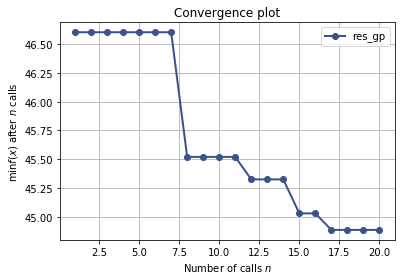

In [108]:
# Convergence traces
results = [
    ('res_gp', res_gp)
]

# Can compare the progress of many strategies by simply passing a list
plot_convergence(*results);

This function helps to visualize the progress of your optimization by showing the best to date result at each iteration. From this plot we can deduce that we need at least 20 iterations for the the minimizer to converge on the objective function. 

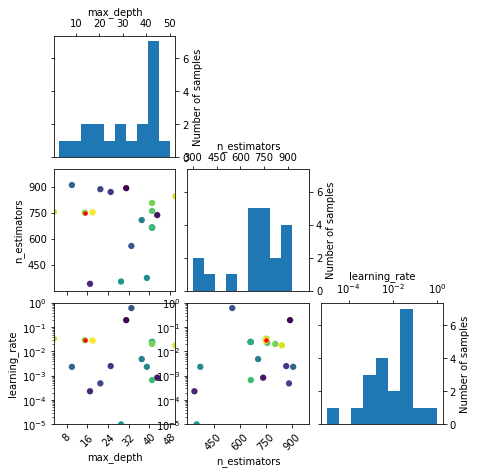

In [109]:
# Evaluating the objective function: we visualize at which points the objective is being evaluated
plot_evaluations(res_gp, bins=10, dimensions=dimensions);

This function helps with visualizing the location and order in which samples are evaluated for objectives with an arbitrary number of dimensions.

The diagonal shows histograms for each of the dimensions. In the off-diagonal plots a two dimensional scatter plot of all points is shown. The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process. You should be able to see that points start clustering around the location of the true miminum. The histograms show that the objective is evaluated more often at locations near to one of the minima.

With the strategy (i.e. gp_hedge) employed we can clearly see that it converges to certain parts of space which it explores more heavily.

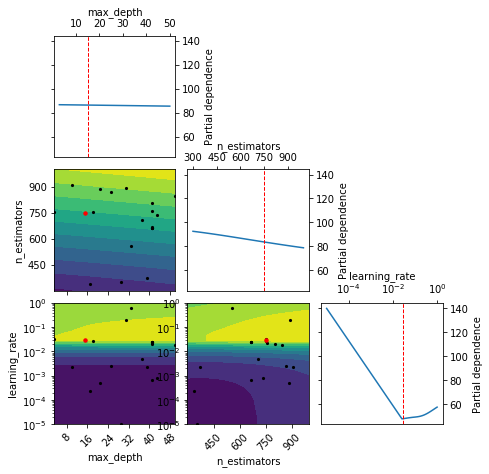

In [110]:
# Pairwise partial dependence plot of the objective function.
plot_objective(res_gp, dimensions=dimensions);

Pairwise scatter plots of the points at which the objective function was directly evaluated are shown on the off-diagonal. A red point indicates the found minimum.

The diagonal shows the partial dependence for one of the dimension with respect to the objective function. The off-diagonal shows the partial dependence for dimensions one of the dimentions and another dimension with respect to the objective function. 

It lets one gain intuition into the score sensitivity with respect to hyperparameters. One can decide which parts of the space may require more fine-grained search and which hyperparameters barely affect the score and can potentially be dropped from the search.

In [111]:
# Set hyper-parameters to best values found by bayesian optimizer
model = lgbm.sklearn.LGBMRegressor(boosting_type='gbdt',
                                   objective='regression',
                                   n_estimators=750,
                                   min_child_samples=10,  
                                   max_depth=15,
                                   learning_rate=0.029238,
                                   categorical_feature=cat_attr_list,
                                   nthread=-1,
                                   random_state=42
                                  )

In [112]:
# Print table with model performance across metric of interested and two other selected metrics.
table = PrettyTable()
table.field_names = ["Model", "Dataset", "Mean Absolute Deviation", "MSE", "Variance"]

In [113]:
%%time
dataset = 'training'
    
# Re-train model on the full training dataset
model.fit(X_train.drop(ignore_column, axis=1), y_train.drop('index', axis=1))
    
# Make prediction training data set used in the variation calculation
y_res  = model.predict(X_train.drop(ignore_column, axis=1))

# Evaluate model performance (for shortness of time will only CV MAE)
mse = -1.0 * np.mean(cross_val_score(model, 
                                     X_train.drop(ignore_column, axis=1), 
                                     y_train.drop('index', axis=1), 
                                     cv=3, 
                                     n_jobs=-1, 
                                     scoring="neg_mean_squared_error"))

# Cross-Validated Mean Absolute Deviation regression loss
mae = -np.mean(cross_val_score(model, 
                               X_train.drop(ignore_column, axis=1), 
                               y_train.drop('index', axis=1), 
                               cv=3, 
                               n_jobs=-1, 
                               scoring="neg_mean_absolute_error"))

variance  = abs(mean_absolute_error(y_train.drop('index', axis=1), y_res) - mae)
print("%.2f" % mean_absolute_error(y_train.drop('index', axis=1), y_res))

    
table.add_row([type(model).__name__,
               dataset,
               format(mae, '.2f'),
               format(mse, '.2f'),   
               format(variance, '.2f')
               ],
             )
    
print(table)

31.84
+---------------+----------+-------------------------+---------+----------+
|     Model     | Dataset  | Mean Absolute Deviation |   MSE   | Variance |
+---------------+----------+-------------------------+---------+----------+
| LGBMRegressor | training |          44.76          | 4516.14 |  12.92   |
+---------------+----------+-------------------------+---------+----------+
CPU times: user 6.86 s, sys: 205 ms, total: 7.07 s
Wall time: 3.26 s


Table summary of model's performance across various evaluation metrics typically used in regression problems.

```
+---------------+----------+-------------------------+---------+----------+
|     Model     | Dataset  | Mean Absolute Deviation |   MSE   | Variance |
+---------------+----------+-------------------------+---------+----------+
| LGBMRegressor | training |          44.76          | 4516.14 |  12.92   |
+---------------+----------+-------------------------+---------+----------+
```

We are most interested in the mean absolute error of the LGBMRegressor model performance after model optimization is 44.76. Although the base value is lower the variance has increase to 12.92 (previous 8.12), this would need further investigation to track down possible reasons, but one possibility is perhaps larger number of cross-validation folds would need to be used to have a more robust model evaluation measurement for the given data sized used.

Amount of time to train this model with 11643 number of samples,

CPU times: user 7.5 s, sys: 288 ms, total: 7.79 s
Wall time: 1.27 s

To train this model on roughly 5M samples would take about 10 minutes, a reasonable amount of time meaning that such a model could be reasonably used in production. Although, this data set makes use of about 10 features normally models leverage if no 100s if not 1000s of features which result in much longer graining time, something to keep in mind.

### Model validation

Here, we check out the models predictions. We use the test data to view how well the model is modeling the data. If something is completely wrong here, we make sure each step in your model is implemented correctly.

In [114]:
# Setup a train test dataframe with just a few features used in scaling features
train_data = pd.DataFrame(
    {
        'dteday'     : X_train['datetime'],
        'temp'       : X_train['temp'],
        'hum'        : X_train['humidity'],
        'windspeed'  : X_train['windspeed'],
        #'casual'     : X_train['casual'],
        #'registered' : X_train['registered'],
        'total_count': y_train['total_count'],
    }
)

test_data = pd.DataFrame(
    {
        'dteday'     : X_test['datetime'],
        'temp'       : X_test['temp'],
        'hum'        : X_test['humidity'],
        'windspeed'  : X_test['windspeed'],
        #'casual'     : X_test['casual'],
        #'registered' : X_test['registered'],
        'total_count': y_test['total_count'],
    }
)

In [115]:
quant_features = ['total_count', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}

for each in quant_features:
    mean, std = train_data[each].mean(), train_data[each].std()
    scaled_features[each] = [mean, std]
    train_data.loc[:, each] = (train_data[each] - mean)/std

We peform a comparison between model predictions on the test dataset to the actual dataset for the first 40 times period (selected arbitrarly) to validate model behavior.

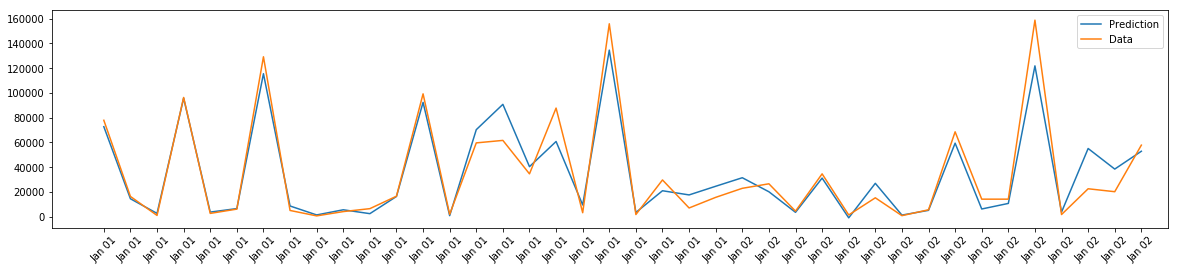

In [116]:
# First 40 time periods
period = 40
fig, ax = plt.subplots(figsize=(20,4))

mean, std   = scaled_features['total_count']
predictions = model.predict(X_test.drop(ignore_column, axis=1)[:period])*std + mean

ax.plot(predictions, label='Prediction')
ax.plot((test_data['total_count'][:period]*std + mean), label='Data')

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(data.ix[y_test.index]['datetime'][:period])
dates = dates.apply(lambda d: d.strftime('%b %d'));

ax.set_xticks(np.arange(len(data.ix[y_test.index][:period])));
_ = ax.set_xticklabels(dates, rotation=45)

From the plot above we observe the prediction cuve folowing similar behavior as what is found in the the actual data. This confirms that the model is performing as we weould expect on new unseen data.

### Model intepretation with SHapley Additive exPlanations

We use a model validation technique called SHAP values, it  allows us to explore the relationships between feature for predicted case. Each feature has its contribution to the final model predicted outcome. SHAP value is a measure of the impact of variables taking into account the interaction with other variables. Shapley values have a theoretical fundamentation in game theory (a game is the prediction task for one single instance).

"Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared." - source

After creating a model, we can plot the shap summary for a rental bike dataset, where the target feature is the count of rents for that particular day.

In [117]:
def show_importances(model, x, kind="bar"):
    """
    @ param: model - preditive model (after tranining)
    @ param: x - test dataset
    @ param: kind - type of plot (e.g. bar plot corresponds to absoluate mean shap-value)
    
    return:
        - shap-summary plot
    """
    explainer   = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
        
    if kind=="bar":
        return shap.summary_plot(shap_values, x, plot_type="bar")
        
    return shap.summary_plot(shap_values, x)

#### Shapley-based feature importance

A measure for feature importance is based on average the absolute mean Shapley values for each feature across the  dataset. 

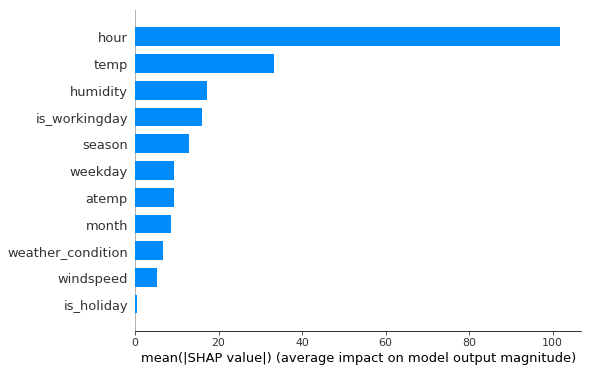

In [118]:
# Shapley-based feature importance ranking: summarize the effects of all the features
show_importances(model, X_test.drop(ignore_column, axis=1)) # global explanation for entire model

The features are rank from most important (top) to least imporant (bottom) for the prediction across the test dataset. Where the The value next to them is the mean SHAP value.

- We can see that the hour as well as the tempeature are very important features.
- The workingday is an important feature as, while other features contribute less to final model prediction.

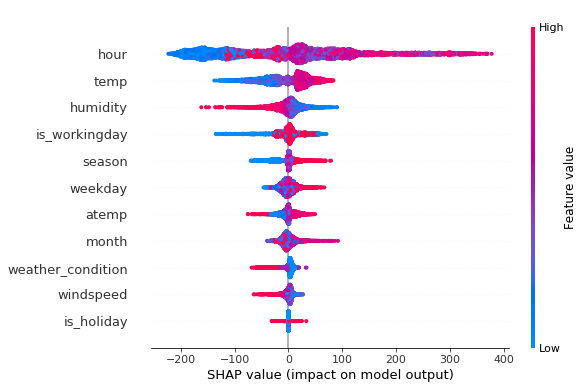

In [119]:
# Feature ranking broken down based on what direction low and high feature values push model's prediction outcome
show_importances(model, X_test.drop(ignore_column, axis=1), kind=None)

Each point represents a row from the original dataset. We can see for example that having a high humidity is associated with high and negative values on the target output. Where high comes from the color (red) and negative from the shap-value (x-axis). In other words, people rent fewer bikes if humidity is high. While Looking at temp feature, we can see how lower temperatures (blue) are associated with a big decrease in shap values (i.e. negative shap values). 

In [120]:
# Model explainer
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.drop(ignore_column, axis=1))

In [121]:
# visualize the first prediction's explanation (local explanation for a given sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.drop(ignore_column, axis=1).iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value, 20.7 (the average model output over the training dataset we passed) to the model output, corresponding to the number of bike usage for that specific sample (in this case the first in the test dataset). Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

The features "temp", slighly high temperature, and "month", of August, are contributing most for this speicific sample point, day of year, towards increasing the number of bike rentals for this day, while "hour" and "humidity" are pushing towards decreasing the number of bike rentals for this day. This makes sence since it's early in the morning, 5 am, and high humidity (0.88 scaled between 0-1 based on the dataset samples). 

In [122]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test.drop(ignore_column, axis=1))

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations across the entire dataset, that is all the samples in the test dataset. From the plot above we can observe that high values (red) of the features themselves tend to have higher variability of the model predicted outcome globally speaking. 

#### SHAP dependence plot

The next two plot provides us with a visualization of Shapley values, a global global overview over the effects of "hour" and "temp" features (selected as they are features that ranks high in importance).

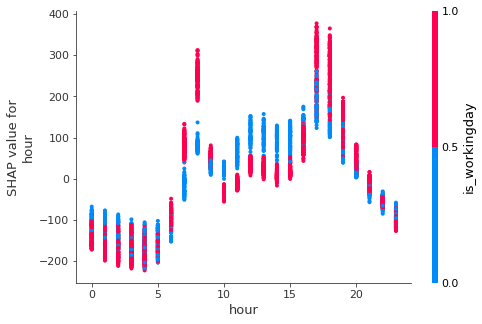

In [123]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("hour", shap_values, X_test.drop(ignore_column, axis=1))

 This SHAP dependence plot shows both the effect and variance on the of the "hour" feature on the predicted outcome. We observe that peaks correspond working days (red = 1.0), in the range of working our starting and ending. While following the blue curve we see it follow the same trend drieven by the weekend as we observed in the data analysis notebook as well, so this gives us confidence that the model is behaving as we would expect, providing validation.

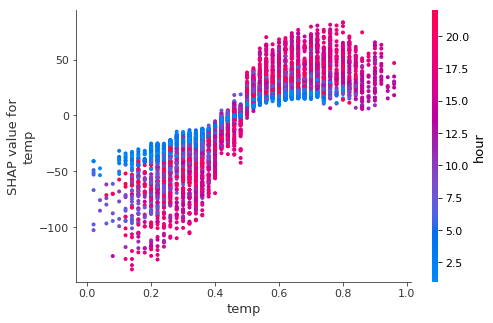

In [124]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("temp", shap_values, X_test.drop(ignore_column, axis=1))

 This SHAP dependence plot shows both the effect and variance on the of the "temperature" feature on the predicted outcome. Following the blue curve (corresponding to early morning hours) contributes to decrease the shap-value for mid to low temparature while this trends reverse after a certain temaparture mainly mid to high temperature levels where this features starts to contribut to incrase the number of big rentals up to a point, 0.8 on this normalized temperature scale where it starts to once again decrease. 

#### Model persistance

Both model and optimization are stored.

In [125]:
# Store an skopt optimization result into a file
from skopt import dump

dump(res=res_gp, filename='artifacts/results.pkl', store_objective=True)

In [ ]:
#  restart training from the saved results via x0 and y0arguments
results = skopt.gp_minimize(func=objective, 
                            dimensions=space,
                            x0=old_results.x_iters,
                            y0=old_results.func_vals,
                            #**HPO_PARAMS
                           )

### Conclusion

Additional studies can be peformed such as exploring other meta-parameter of the algorithms to test for further model performance this study establishes a through baseline. Furthemore, the result corresponds to the high correlation of the hour and temperature variable with the bicycle sharing count driving the model's prediction. We expect this model basedon on LGBMRegressor algorithm to perform with a mean absolute deviation of 26.47 +/- 9.91 new unseen data.  

### Part 2


    The majority of the machine learning algorithms used to model data and make predictions such as those found in open source packages like scikit-learn, xgboost, lightgbm, and catboost rely on pandas data frames. Pandas data frames read in all the data into memory and for this reason it can usually manage 1-2 million rows and 20-50 columns or in other words from 100M to 2GB of data depending on the exact data density and hardware configurations. We will run into scaling issues for larger datasets due to insufficient memory, especially on the order of several terabytes.

    There are technologies designed to work with extremely large datasets. One popular tool is Apache Spark which is can perform distributive computing but taking full advantage of their capabilities usually requires more expensive hardware. Unfortunately, they lack rich feature sets for high quality data cleaning, exploration, and analysis that is often found with pandas. 

    In order to deal with the storage issue we can convert the data into parquet files and store it all on a Hadoop cluster. Parquet stores nested data structures in a flat columnar format. Compared to a traditional approach where data is stored in row-oriented approach, parquet is more efficient in terms of storage and performance. Spark integrates quite nicely with Hadoop clusters both of which can help resolve our scaling problems with storage and computing. Spark has a machine learning library for random forest and gradient boosting but are not yet well integrated with packages like xgboost. Microsoft Machine Learning for Apache Spark, known as mmlspark, allows lightgbm to integrate with spark data frames. In practice, we would read in the parquet files as pyspark data frames and use them with the predictive algorithms just described.

    With such large dataset one can employ services like AWS to leverage their infrastructure efficiency for both storage and computing resources capable of handling such scales as well as for model deployment purposes to provide model inference predictions on new unseen data in batch or real-time data. For example, can employ AWS Glue to fully managed ETL service, Amazon Redshift for cost-effective data warehousing, and Sagemaker to fully managed the entire machine learning workflow. 
    
    I have some experience with pyspark and consider myself to have working proficiency ingesting, cleaning, and manipulating data with these tools, as well as developing and training models, like gradient boosting. Some of the computation performed for this data challenge was performed on AWS (SageMaker, S3 bucket, CloudWatch services).